# R&I Machine learning assignement
## BELFADIL Anas & HAKEAMA ABOUFAKHER Ahid
### 04/11/2019

### I-Introduction:

We choosed to work on an interesting problem wich is currently open as a competition on [ASHRAE - Great Energy Predictor III - kaggle](https://www.kaggle.com/c/ashrae-energy-prediction/data).\
In this problem we are given the data for the hourly energy consumption of 1450 buildings for the year 2016, and the goal is to find the best model that could infer what the hourly energy consumption for this buildings would be like for the years 2017 and 2018.\ 
This model would be used to predict the conterfactual energy consumption of these buildings, have they not been rehabilitated to improve their energy efficiency, and to estimate the gains made and the impact of similar investements in the futur.\

### II-Data exploration:
In this section we will explore and visualize the data and try to find possible patterns.

Setting up the environement:

In [1]:
import os
import psutil
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib
import matplotlib.pyplot as plt
from dateutil.parser import parse
from datetime import datetime
from scipy.stats import randint
import xgboost as xgb

import seaborn as sns   # for statistical data visualisation
sns.set_style("whitegrid")


import cufflinks as cf
cf.go_offline(connected=False)

from IPython.display import Markdown
def bold(string):
    display(Markdown(string))

#### 1-A fisrt look at the data
List of the data files provided for this problem:

In [2]:
print(os.listdir("/home/anas/ml/ashrae-energy-prediction"))

['test.csv', 'building_metadata.csv', 'train.csv', 'weather_train.csv', 'weather_test.csv', 'sample_submission.csv']


There are 6 files, let's explore them!
For this it's better to use a function instead of repeating the same process 6 times.

In [3]:
# Function to read and do the initial data interpretation
def read_data(filename):
    path = "/home/anas/ml/ashrae-energy-prediction"
    df = pd.read_csv('{0}/{1}'.format(path,filename))
    bold('**Shape of the data**')
    display(df.shape)
    bold('**Columns and their datatype**')
    display(df.info())
    if 'timestamp' in df.columns: 
        df['timestamp'] = pd.to_datetime(df['timestamp'],format = "%Y-%m-%d %H:%M:%S")
        bold('**Year of the data**')
        print(df.timestamp.dt.year.unique())
    bold('**Glimpse at the data**')
    display(df.head())
    return df

**train.csv:**\
This file has 4 columns and 20 216 100 rows, it contains the hourly reading of the energy consumption of 1450 buildings for the whole year 2016.\
The columns are :\
-**building_id**\
-**The meter id code** {0: electricity, 1: chilledwater, 2: steam, 3: hotwater} 
\
-**timestamp** is for the time the measurement was taken (hourly values)\
-and lastely and most importantly **meter_reading** which is our target column.

In [4]:
train = read_data('train.csv')

**Shape of the data**

(20216100, 4)

**Columns and their datatype**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB


None

**Year of the data**

[2016]


**Glimpse at the data**

building_id  meter  timestamp  meter_reading
0            0      0 2016-01-01            0.0
1            1      0 2016-01-01            0.0
2            2      0 2016-01-01            0.0
3            3      0 2016-01-01            0.0
4            4      0 2016-01-01            0.0

**building_metadata.csv:** \ 
This file has 6 columns and 1449 rows, it contains information about the 1450 building of the data.\
-**site_id** - Foreign key for the weather files.\
-**building_id** - Foreign key for training.csv\
-**primary_use** - Indicator of the primary category of activities for the building based on EnergyStar property type definitions\
-**square_feet** - Gross floor area of the building\
-**year_built** - Year building was opened\
-**floor_count** - Number of floors of the building\

In [5]:
building_metadata = read_data("building_metadata.csv")

**Shape of the data**

(1449, 6)

**Columns and their datatype**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     675 non-null float64
floor_count    355 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


None

**Glimpse at the data**

site_id  building_id primary_use  square_feet  year_built  floor_count
0        0            0   Education         7432      2008.0          NaN
1        0            1   Education         2720      2004.0          NaN
2        0            2   Education         5376      1991.0          NaN
3        0            3   Education        23685      2002.0          NaN
4        0            4   Education       116607      1975.0          NaN

**weather_train.csv:** \ 
It contains weather data from a meteorological station as close as possible to the site. it has 139 773 rows and 9 columns:
\
**site_id**
**air_temperature** - Degrees Celsius
**cloud_coverage** - Portion of the sky covered in clouds, in oktas
**dew_temperature** - Degrees Celsius
**precip_depth_1_hr** - Millimeters
**sea_level_pressure** - Millibar/hectopascals
**wind_direction** - Compass direction (0-360)
**wind_speed** - Meters per second

In [6]:
weather_train = read_data("weather_train.csv")

**Shape of the data**

(139773, 9)

**Columns and their datatype**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int64
timestamp             139773 non-null object
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float64
wind_speed            139469 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB


None

**Year of the data**

[2016]


**Glimpse at the data**

site_id           timestamp  air_temperature  cloud_coverage  \
0        0 2016-01-01 00:00:00             25.0             6.0   
1        0 2016-01-01 01:00:00             24.4             NaN   
2        0 2016-01-01 02:00:00             22.8             2.0   
3        0 2016-01-01 03:00:00             21.1             2.0   
4        0 2016-01-01 04:00:00             20.0             2.0   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
0             20.0                NaN              1019.7             0.0   
1             21.1               -1.0              1020.2            70.0   
2             21.1                0.0              1020.2             0.0   
3             20.6                0.0              1020.1             0.0   
4             20.0               -1.0              1020.0           250.0   

   wind_speed  
0         0.0  
1         1.5  
2         0.0  
3         0.0  
4         2.6

#### 2- Reducing the memory usage of the data: 
Using this function from [Kaggle](https://www.kaggle.com/kernels/scriptcontent/3684066/download) we can iterate through all the columns of a dataframe and modify the data type to reduce memory usage. 

In [7]:
# source: https://www.kaggle.com/kernels/scriptcontent/3684066/download

def reduce_mem_usage(df):
    #iterate through all the columns of a dataframe and modify the data type
    #to reduce memory usage.        

    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if (col_type != "object" and col_type != "datetime64[ns]"):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [8]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.90 MB
Decreased by 71.8%


In [9]:
building_metadata = reduce_mem_usage(building_metadata)

Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.8%


In [10]:
weather_train = reduce_mem_usage(weather_train)

Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 2.65 MB
Decreased by 72.4%


**Let's merge the train informations into one file**

In [11]:
df = train.merge(building_metadata, on='building_id', how='left')
df = df.merge(weather_train, on=['site_id', 'timestamp'], how='left')
df.head()

building_id  meter  timestamp  meter_reading  site_id primary_use  \
0            0      0 2016-01-01            0.0        0   Education   
1            1      0 2016-01-01            0.0        0   Education   
2            2      0 2016-01-01            0.0        0   Education   
3            3      0 2016-01-01            0.0        0   Education   
4            4      0 2016-01-01            0.0        0   Education   

   square_feet  year_built  floor_count  air_temperature  cloud_coverage  \
0         7432      2008.0          NaN             25.0             6.0   
1         2720      2004.0          NaN             25.0             6.0   
2         5376      1991.0          NaN             25.0             6.0   
3        23685      2002.0          NaN             25.0             6.0   
4       116607      1975.0          NaN             25.0             6.0   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
0             20.0                NaN              1019.5             0.0   
1             20.0                NaN              1019.5             0.0   
2             20.0                NaN              1019.5             0.0   
3             20.0                NaN              1019.5             0.0   
4             20.0                NaN              1019.5             0.0   

   wind_speed  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0

#### 3- Visualizing the data:
##### a- Missing values:
**Train.csv:**
The goal here is to visualize for each building and meter pair, where are the missing values and zero values VS time\
Credit to [caesarlupum](https://www.kaggle.com/caesarlupum)

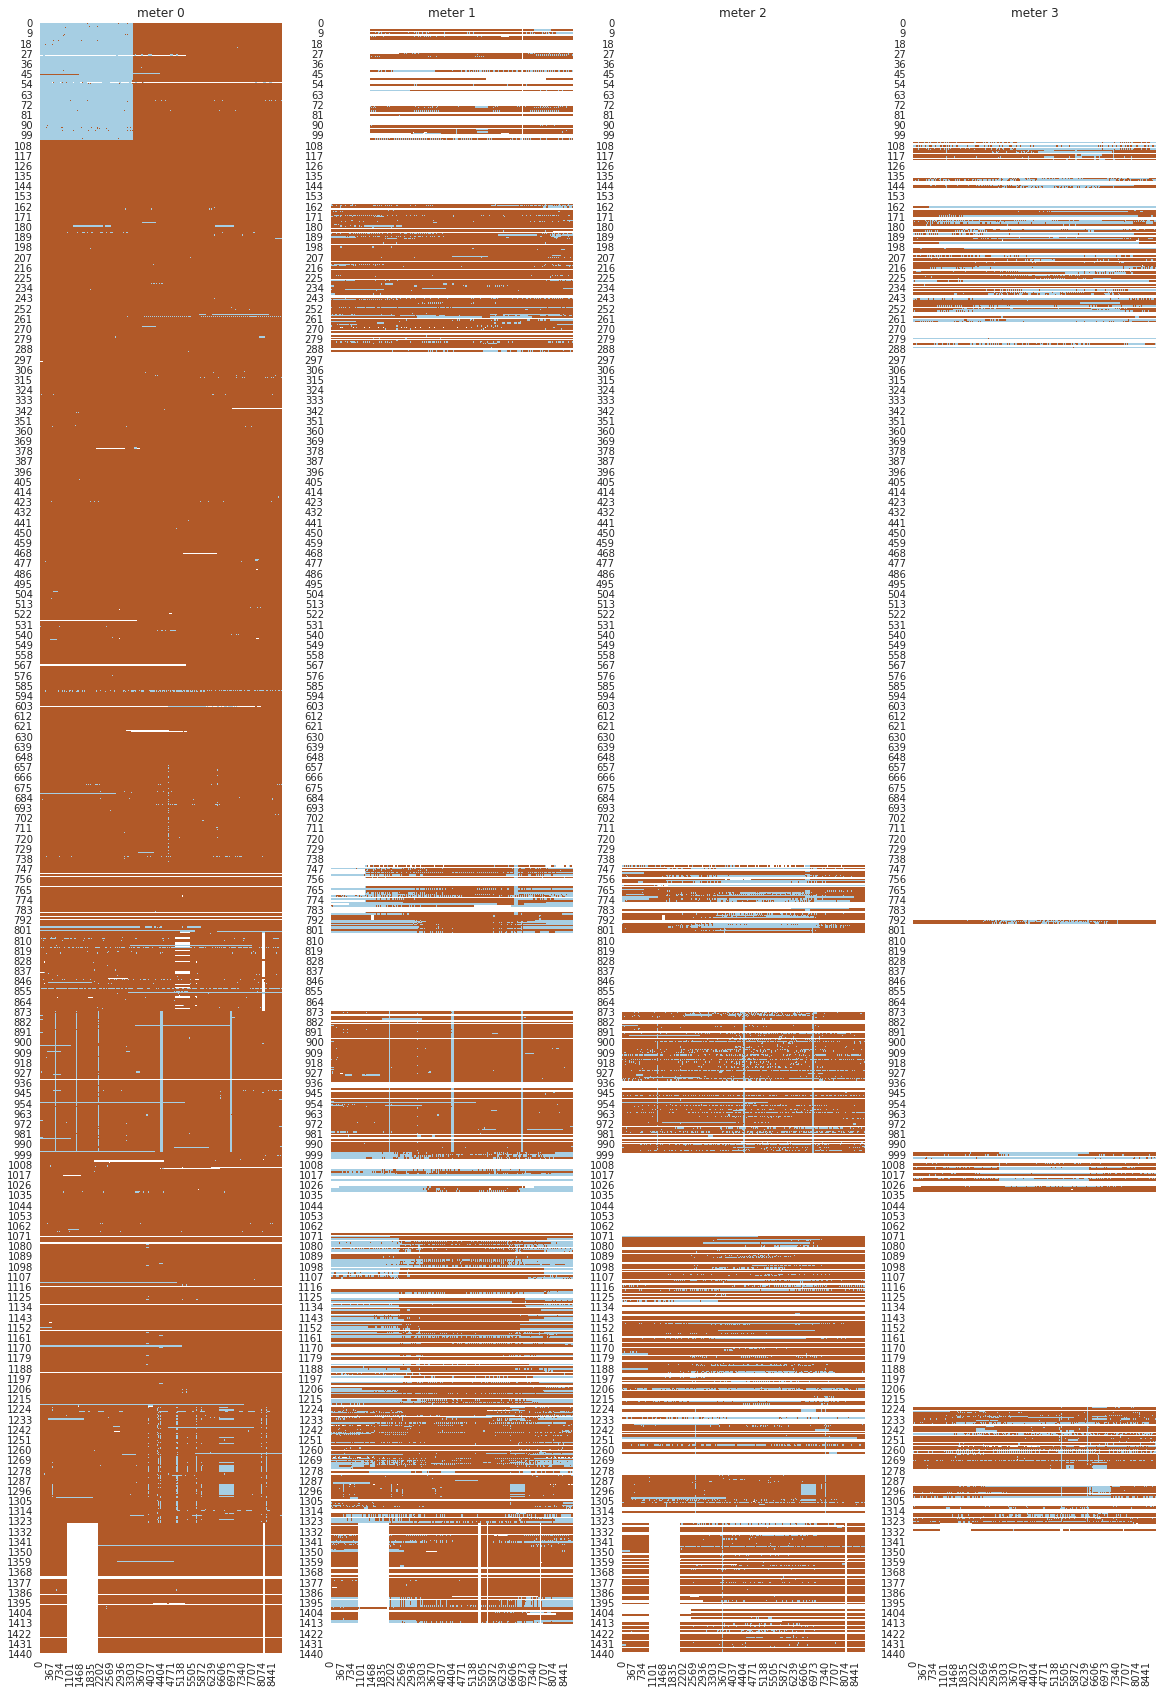

In [66]:
# Load data
train_df = train.set_index(['timestamp'])

# Plot missing values per building/meter
f,a=plt.subplots(1,4,figsize=(20,30))
for meter in np.arange(4):
    df = train_df[train_df.meter==meter].copy().reset_index()
    df['timestamp'] = pd.to_timedelta(df.timestamp).dt.total_seconds() / 3600
    df['timestamp'] = df.timestamp.astype(int)
    df.timestamp -= df.timestamp.min()
    missmap = np.empty((1449, df.timestamp.max()+1))
    missmap.fill(np.nan)
    for l in df.values:
        if l[2]!=meter:continue
        missmap[int(l[1]), int(l[0])] = 0 if l[3]==0 else 1
    a[meter].set_title(f'meter {meter:d}')
    sns.heatmap(missmap, cmap='Paired', ax=a[meter], cbar=False)

Legend:

- X axis: hours elapsed since Jan 1st 2016, for each of the 4 meter types
- Y axis: building_id
- Brown: meter reading available with non-zero value
- Light blue: meter reading available with zero value
- White: missing meter reading

We notice that almost all the buildings have the electricity meter, but the other meters are missing in a lot of cases.\
We also remarque that there are some zero values that are suspicious: the blue vertical lignes, especialy for the 105 first buildings where we have zero until 20 May.\

A summary of missing values for the merged files should give us the numbers of NA's for each column

In [11]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(16)

Total    Percent
floor_count         16709167  82.652772
year_built          12127645  59.990033
cloud_coverage       8825365  43.655131
precip_depth_1_hr    3749023  18.544739
wind_direction       1449048   7.167792
sea_level_pressure   1231669   6.092515
wind_speed            143676   0.710701
dew_temperature       100140   0.495348
air_temperature        96658   0.478124
square_feet                0   0.000000
primary_use                0   0.000000
site_id                    0   0.000000
meter_reading              0   0.000000
timestamp                  0   0.000000
meter                      0   0.000000
building_id                0   0.000000

##### b- A look at some examples:
We plot the energy consumption/meter_type for some buildings side to side with the air_temperature 

In [86]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use('seaborn')

def look_at(building_id):
    meters = df[df['building_id'] == building_id].meter.unique() 
    for meter in meters:
        if meter == 0:
            meter_name = 'Electricity' 
        elif meter == 1:
            meter_name = 'Chilledwater'
        elif meter == 2:
            meter_name = 'Steam'
        else:
            meter_name = 'Hotwater'
        fig, ax = plt.subplots(figsize=(15,5))
        plt.title(f'Building {building_id} Meter {meter_name}')
        ax2 = ax.twinx()
        # plot meter_reading
        idx = (df['building_id'] == building_id) & (df['meter'] == meter)
        dates = matplotlib.dates.date2num(df.loc[idx, 'timestamp'])
        ax2.plot_date(dates, df.loc[idx, 'meter_reading'], '-', label='meter_reading', alpha=0.8)
        # plot air_temperature
        dates = matplotlib.dates.date2num(df.loc[train['building_id'] == building_id, 'timestamp'])
        ax.plot_date(dates, df.loc[train['building_id'] == building_id, 'air_temperature'], '.', color='tab:cyan', label='air_temperature', linestyle = 'solid')
        ax.set_ylabel('air_temperature'); ax2.set_ylabel('meter_reading')
        ax.legend(loc='upper left'); ax2.legend(loc='upper right')

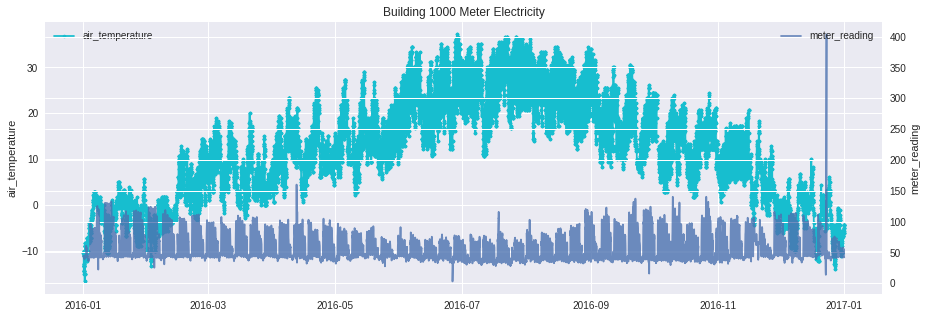

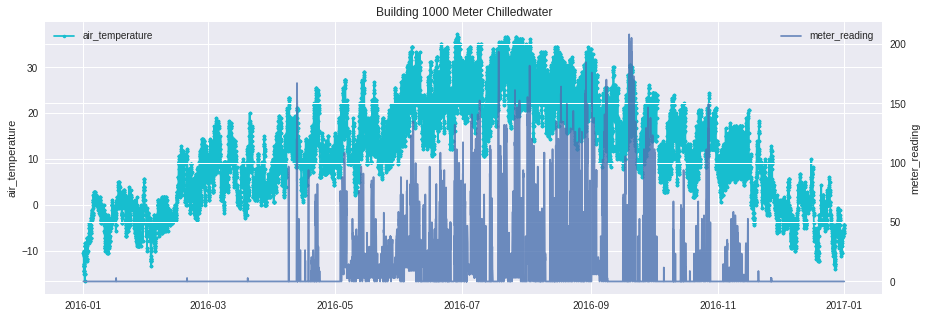

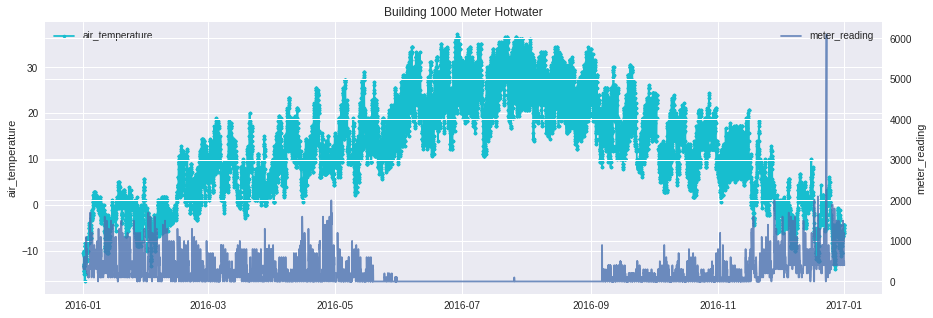

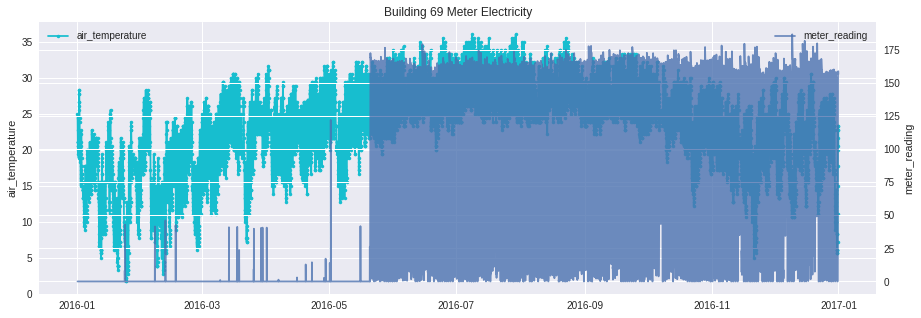

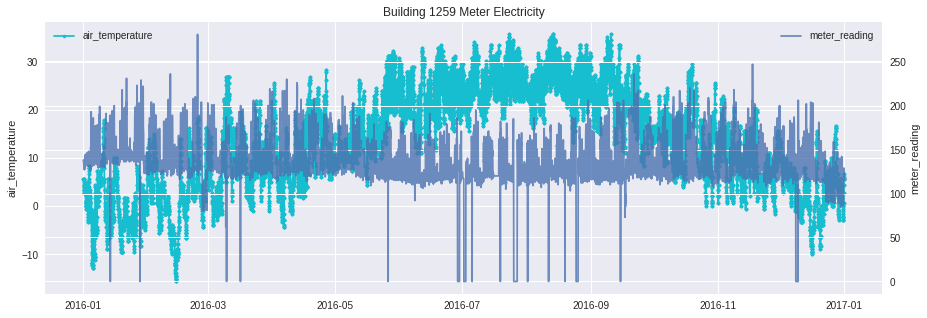

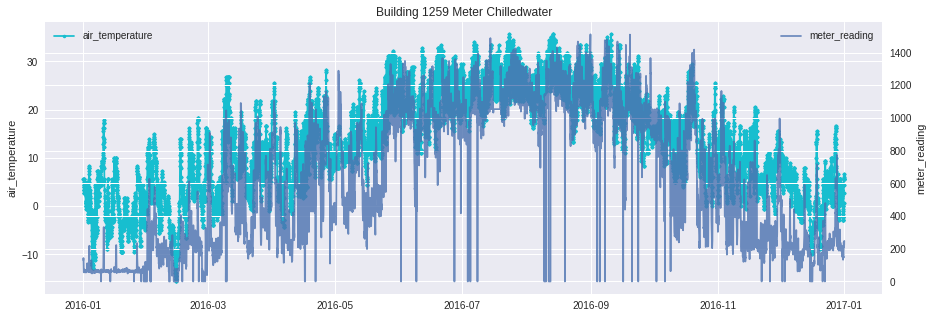

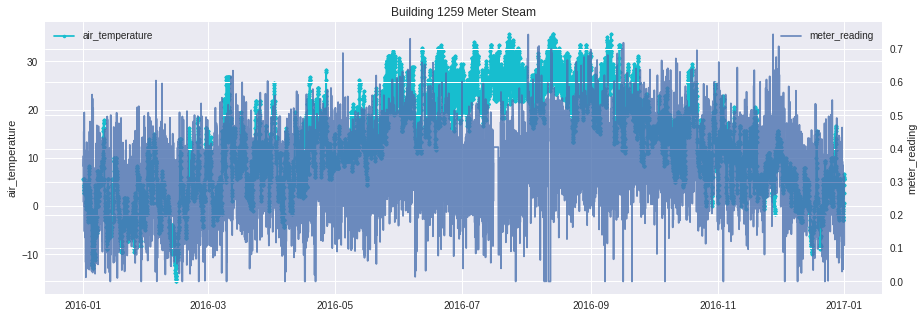

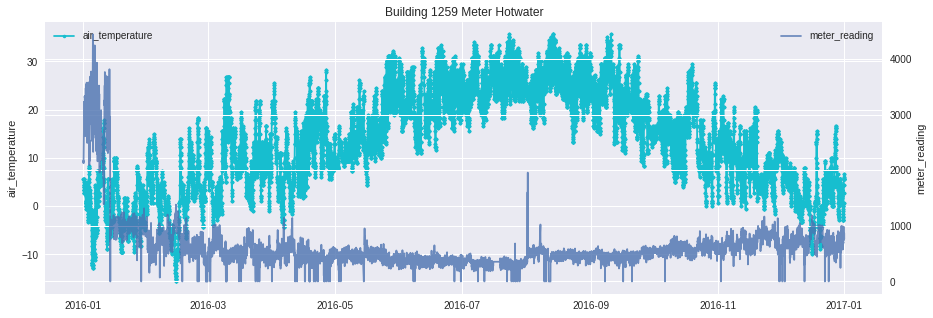

In [87]:
look_at(1000)
look_at(69)
look_at(1259)

We can definetly see some correlations going on between the meters readings and the air_temperature, it's very clear in the case of building 1259 Meter Chiledwater where we have a strong positif correlation, and in the case of building 1000 Meter Hotwater we notice a negatif correlation with the air_temperature.
We also notice a certain periodicity of the data that need a zoom on to see more closely, so let's zoom in!

In [93]:
import time
from datetime import datetime
from matplotlib import dates as mpl_dates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

df['timestamp'] = df['timestamp'].astype('datetime64[ns]')

def look_closely_at(building_id, start_date, end_date):
    meters = df[df['building_id'] == building_id].meter.unique() 
    for meter in meters:
        if meter == 0:
            meter_name = 'Electricity' 
        elif meter == 1:
            meter_name = 'Chilledwater'
        elif meter == 2:
            meter_name = 'Steam'
        else:
            meter_name = 'Hotwater'
        fig, ax = plt.subplots(figsize=(15,5))
        plt.title(f'Building {building_id} Meter {meter_name}')
        # plot meter_reading
        idx = (df['building_id'] == building_id) & (df['meter'] == meter) & (df['timestamp'] > start_date) & (df['timestamp'] <= end_date)
        dates = matplotlib.dates.date2num(df.loc[idx, 'timestamp'])
        plt.plot_date(dates, df.loc[idx, 'meter_reading'], '-', label='meter_reading', alpha=0.8)
        plt.gcf().autofmt_xdate()

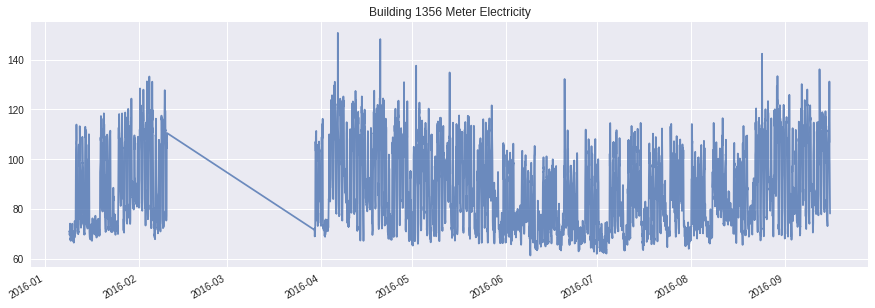

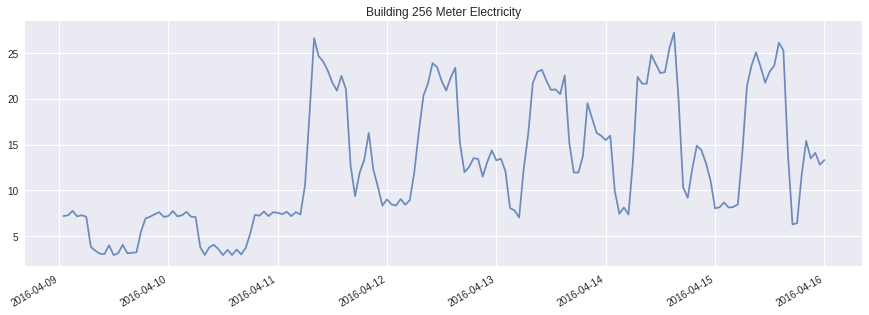

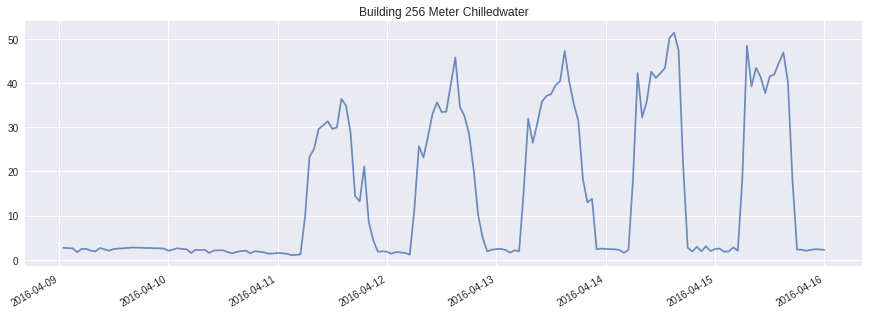

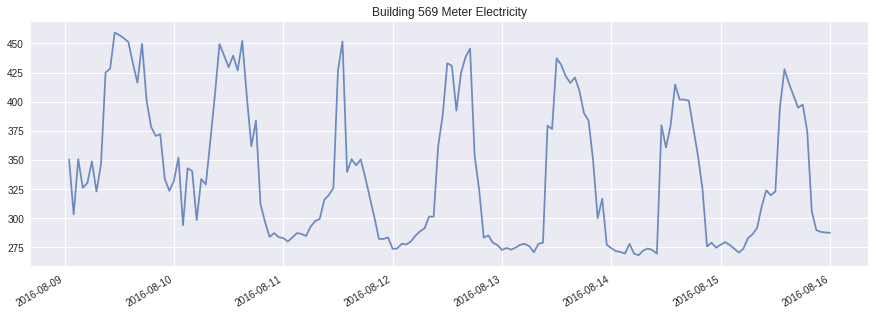

In [94]:
look_closely_at(1356, '2016-01-09', '2016-09-16')
look_closely_at(256, '2016-04-09', '2016-04-16')
look_closely_at(569, '2016-08-09', '2016-08-16')

We notice that the structure of the meter readings is very different from a meter to another. 

### III- Setting aside the test set:
A look at the distribution of data per meter type shows that the distribution is skewed to the Electricity meter, so to creat a balanced test set we should use a stratification methode.\
We can also just separate the data for each meter and do 4 models, one for every meter, instead of one.

**Electricity is the most frequent meter**

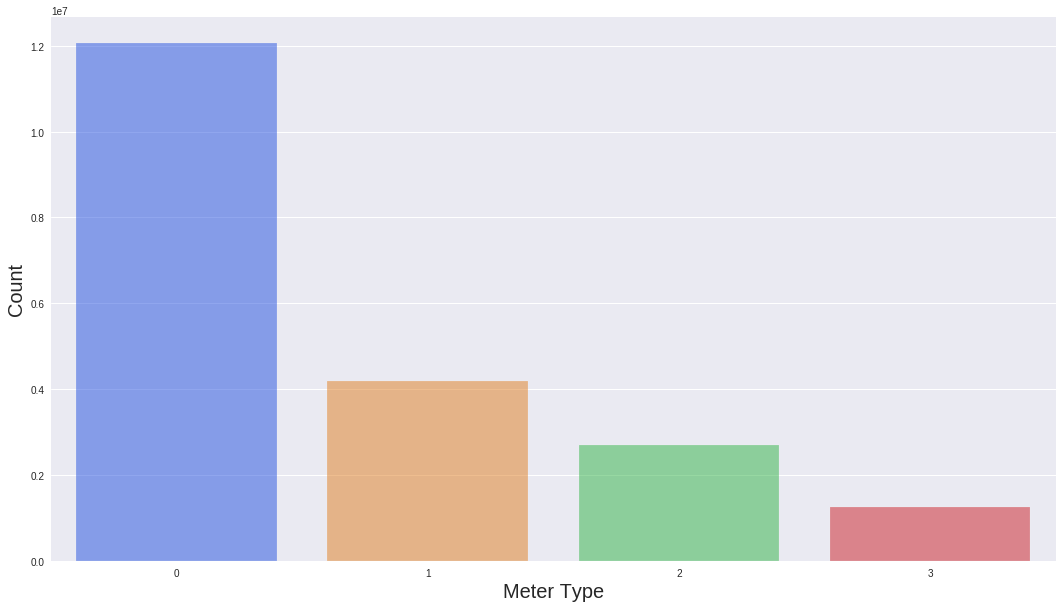

In [88]:
bold('**Electricity is the most frequent meter**')
plt.rcParams['figure.figsize'] = (18, 10)
ax = sns.countplot(data = train, x ='meter', palette = 'bright', alpha = 0.5)
ax.set_ylabel('Count', fontsize = 20)
ax.set_xlabel('Meter Type', fontsize = 20)
plt.show()

For this exercice, to simplify we decided to work just on the electricity meter.
We will also drop the suspicious zeros of the first 105 buildings.

In [12]:
Data = df[(df.building_id>=105)|(df.timestamp.astype('datetime64[ns]')>'2016-05-20')] 
Data = Data[Data.meter==0]
Data = Data.reset_index().drop(columns=['index'])
Data

building_id  meter           timestamp  meter_reading  site_id  \
0                 105      0 2016-01-01 00:00:00      23.303600        1   
1                 106      0 2016-01-01 00:00:00       0.374600        1   
2                 107      0 2016-01-01 00:00:00     175.184006        1   
3                 108      0 2016-01-01 00:00:00      91.265297        1   
4                 109      0 2016-01-01 00:00:00      80.930000        1   
...               ...    ...                 ...            ...      ...   
11714691         1444      0 2016-12-31 23:00:00       8.750000       15   
11714692         1445      0 2016-12-31 23:00:00       4.825000       15   
11714693         1446      0 2016-12-31 23:00:00       0.000000       15   
11714694         1447      0 2016-12-31 23:00:00     159.574997       15   
11714695         1448      0 2016-12-31 23:00:00       2.850000       15   

                            primary_use  square_feet  year_built  floor_count  \
0                             Education        50623         NaN          5.0   
1                             Education         5374         NaN          4.0   
2                             Education        97532      2005.0         10.0   
3                             Education        81580      1913.0          5.0   
4                             Education        56995      1953.0          6.0   
...                                 ...          ...         ...          ...   
11714691  Entertainment/public assembly        19619      1914.0          NaN   
11714692                      Education         4298         NaN          NaN   
11714693  Entertainment/public assembly        11265      1997.0          NaN   
11714694            Lodging/residential        29775      2001.0          NaN   
11714695                         Office        92271      2001.0          NaN   

          air_temperature  cloud_coverage  dew_temperature  precip_depth_1_hr  \
0                3.800781             NaN         2.400391                NaN   
1                3.800781             NaN         2.400391                NaN   
2                3.800781             NaN         2.400391                NaN   
3                3.800781             NaN         2.400391                NaN   
4                3.800781             NaN         2.400391                NaN   
...                   ...             ...              ...                ...   
11714691         1.700195             NaN        -5.601562               -1.0   
11714692         1.700195             NaN        -5.601562               -1.0   
11714693         1.700195             NaN        -5.601562               -1.0   
11714694         1.700195             NaN        -5.601562               -1.0   
11714695         1.700195             NaN        -5.601562               -1.0   

          sea_level_pressure  wind_direction  wind_speed  
0                     1021.0           240.0    3.099609  
1                     1021.0           240.0    3.099609  
2                     1021.0           240.0    3.099609  
3                     1021.0           240.0    3.099609  
4                     1021.0           240.0    3.099609  
...                      ...             ...         ...  
11714691              1008.5           180.0    8.796875  
11714692              1008.5           180.0    8.796875  
11714693              1008.5           180.0    8.796875  
11714694              1008.5           180.0    8.796875  
11714695              1008.5           180.0    8.796875  

[11714696 rows x 16 columns]

In [89]:
total = Data.isnull().sum().sort_values(ascending = False)
percent = (Data.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(16)

Total    Percent
floor_count         8749869  43.281686
year_built          6470035  32.004368
cloud_coverage      5168930  25.568384
precip_depth_1_hr   2513576  12.433536
sea_level_pressure  1012519   5.008478
wind_direction       670982   3.319048
wind_speed            66795   0.330405
dew_temperature       48782   0.241303
air_temperature       47016   0.232567
square_feet               0   0.000000
primary_use               0   0.000000
site_id                   0   0.000000
meter_reading             0   0.000000
timestamp                 0   0.000000
meter                     0   0.000000
building_id               0   0.000000

A look at the distribution of data per primary_use type shows that the distribution is also skewed to the Education category, so to creat a balanced test set we use the stratification methode for the primary_use category.\

**Education is the most frequent primary_use**

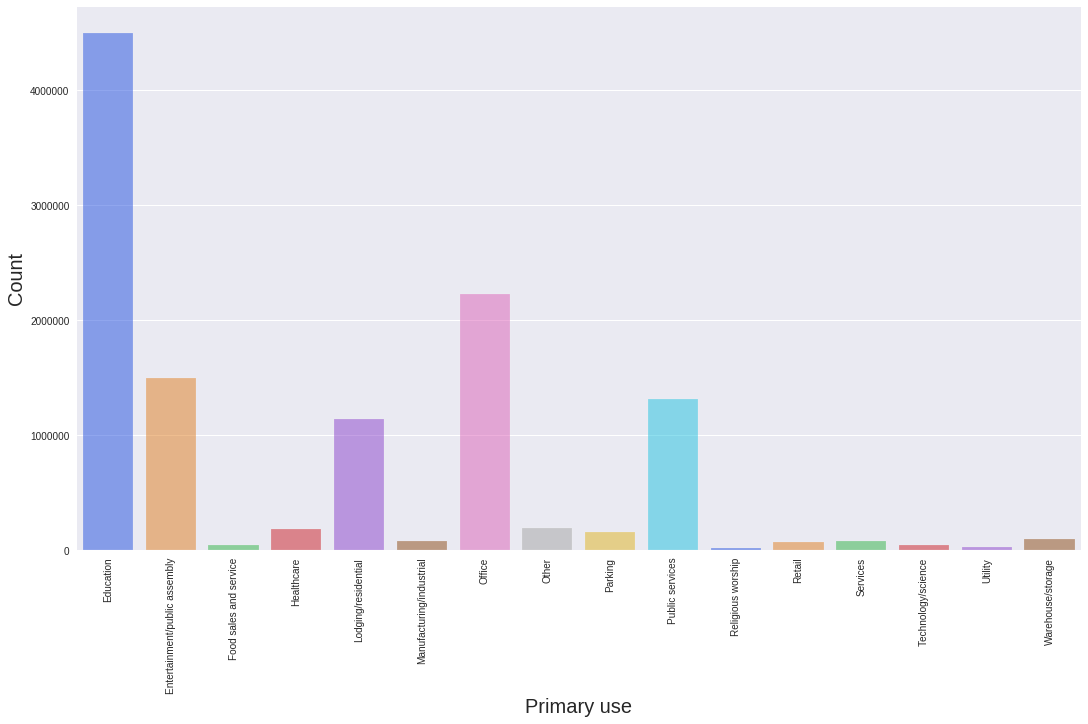

In [90]:
bold('**Education is the most frequent primary_use**')
plt.rcParams['figure.figsize'] = (18, 10)
ax = sns.countplot(data = Data, x ='primary_use', palette = 'bright', alpha = 0.5)
ax.set_ylabel('Count', fontsize = 20)
ax.set_xlabel('Primary use', fontsize = 20)
plt.xticks(rotation=90)
plt.show()

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit


split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(Data, Data["primary_use"]):
    train_sample = Data.loc[train_index]
    test_sample = Data.loc[test_index]

Let’s see if our sets have being stratified correctly :

In [14]:
bold('**Over all porportion of each primary_use**')
print(Data["primary_use"].value_counts() / len(Data))

bold('**Porportion of each primary_use with stratification**')
print(test_sample["primary_use"].value_counts() / len(test_sample))

**Over all porportion of each primary_use**

Education                        0.384115
Office                           0.190481
Entertainment/public assembly    0.127576
Public services                  0.112683
Lodging/residential              0.097172
Other                            0.016677
Healthcare                       0.015736
Parking                          0.013706
Warehouse/storage                0.008799
Manufacturing/industrial         0.007274
Services                         0.006739
Retail                           0.006526
Technology/science               0.003865
Food sales and service           0.003741
Utility                          0.002772
Religious worship                0.002137
Name: primary_use, dtype: float64


**Porportion of each primary_use with stratification**

Education                        0.384116
Office                           0.190481
Entertainment/public assembly    0.127576
Public services                  0.112683
Lodging/residential              0.097172
Other                            0.016677
Healthcare                       0.015736
Parking                          0.013706
Warehouse/storage                0.008799
Manufacturing/industrial         0.007274
Services                         0.006739
Retail                           0.006526
Technology/science               0.003865
Food sales and service           0.003741
Utility                          0.002772
Religious worship                0.002137
Name: primary_use, dtype: float64


Perfect!

In [15]:
#deleting big duplicated data
del  df

### III- Feature engineering:
#### 1- Decomposing Timestamp and framing the timeseries problem as a regression problem:
Machine learning models don't accept the timedate format, so a decomposition of the timestamp variable to hours, days, weeks, months and year should be done. To introduce the cycle nature of this periods we are going to apply a cyclic encoder, thus changing the problem from a timeseries prediction to a regression problem that could be handled with trees models.

In [16]:
train_sample['timestamp'] = pd.to_datetime(train_sample['timestamp'])

In [17]:
def transform(df):
    df['hour'] = np.uint8(df['timestamp'].dt.hour)
    df['day'] = np.uint8(df['timestamp'].dt.day)
    df['weekday'] = np.uint8(df['timestamp'].dt.weekday)
    df['month'] = np.uint8(df['timestamp'].dt.month)
    df['year'] = np.uint8(df['timestamp'].dt.year-1900)
    
    return df

In [18]:
train_sample = transform(train_sample)

In [19]:
def encode_cyclic_feature(df, col, max_vals):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_vals)
#     df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_vals)
    del df[col]
    return df

In [20]:
train_sample = encode_cyclic_feature(train_sample, 'weekday', 7)
train_sample = encode_cyclic_feature(train_sample, 'hour', 24)
train_sample = encode_cyclic_feature(train_sample, 'day', 31)
train_sample = encode_cyclic_feature(train_sample, 'month', 12)

#### 2- Missing and zero values:
We noticed in II-3-a that the first 105 buildings had zero values until the 20th of May, we think that this values should be treated as missing values and not zeros.\
To handle missing values we can:\
- Delete the instances with missing values
- Impute with the mean
- Impute with the median
- Do manuel replacement of the NA values
- Impute with random samples from the same instance\
**Time-Series specific method:**
- Do last observation carried forward (LOCF)
- Do next observation carried backward (NOCB)
- Linear interpolation
- Spline interpolation\ 
These methods rely on the assumption that adjacent observations are similar to one another.\
##### a- Train.csv
**The meter_reading variable**
For the meter_reading variable we have periodes of missig data that are relatively big (see examples below), so the methods described before will not work, idealy a backcasting method could be used for the the buildings 0 to 104 where we don't have the first months readings, and we ca use a combined forecasting/backcasting methode for when the missing data is in the middle.\
As a first model we will delete this suspicious values as stated earlier.

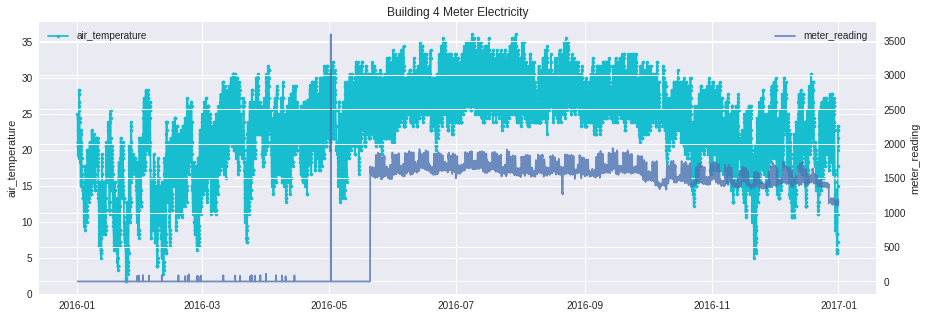

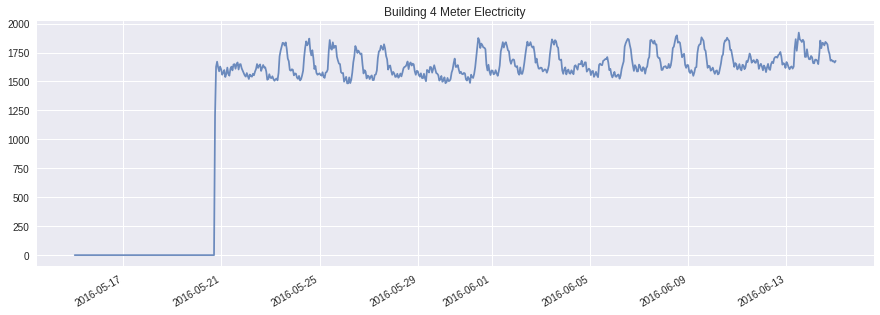

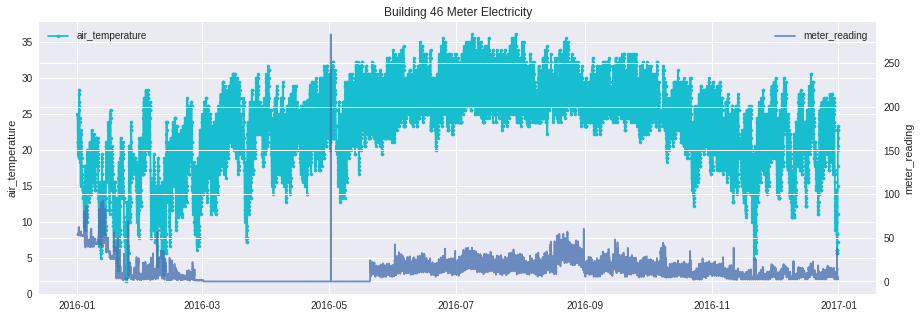

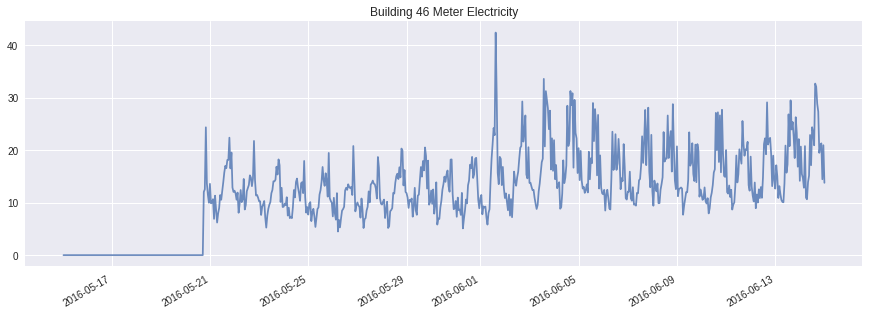

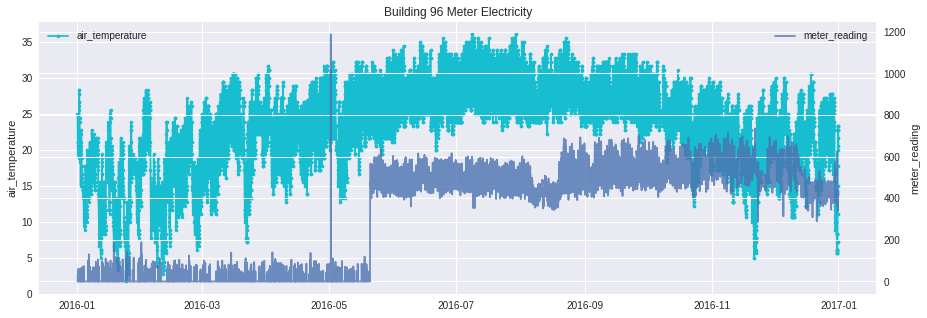

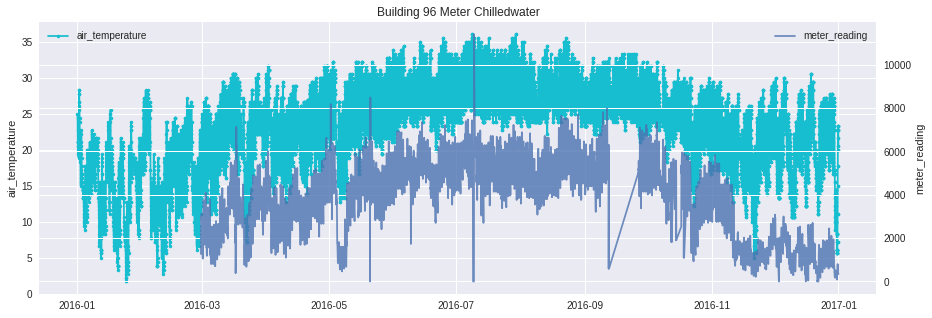

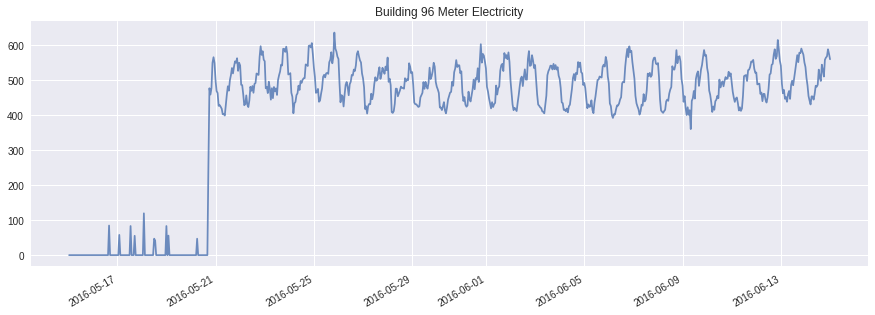

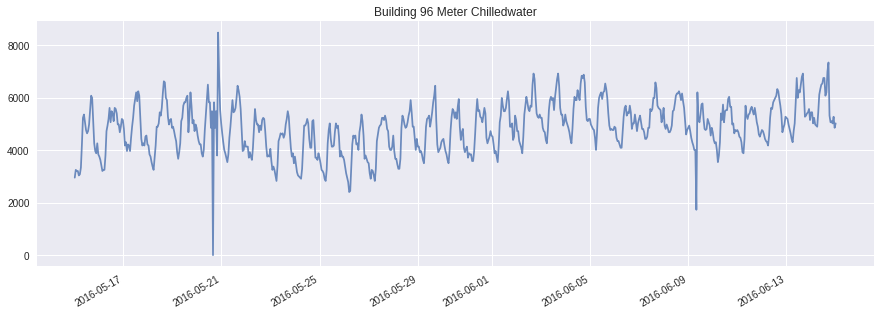

In [95]:
look_at(4)
look_closely_at(4, '2016-05-15', '2016-06-15')
look_at(46)
look_closely_at(46, '2016-05-15', '2016-06-15')
look_at(96)
look_closely_at(96, '2016-05-15', '2016-06-15') 

##### b- building_metadata.csv
##### **floor_count**
floor_count is the variable with the most missing values ~ 74.7%, year of build is also missing alot: 60% of values. Let's explore these variables more to be able to define a good replacement for the missing values, intuitively a grouping by the primary_use seems to be a logical way to cluster these variables, more over we think that energy consumption could be correlated (for one type of primary_use) with the tolal area = square_area * floor_count. 
To verify this lets plot the mean consumption per year per building vs the total area for each primary use.

In [13]:
total = train_sample.isnull().sum().sort_values(ascending = False)
percent = (train_sample.isnull().sum()/train_sample.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(16)

Total    Percent
floor_count         7000182  74.694454
year_built          5177234  55.242945
cloud_coverage      4136802  44.141162
precip_depth_1_hr   2010416  21.451860
sea_level_pressure   809096   8.633345
wind_direction       537103   5.731082
wind_speed            53407   0.569872
dew_temperature       39022   0.416379
air_temperature       37614   0.401355
square_feet               0   0.000000
primary_use               0   0.000000
site_id                   0   0.000000
meter_reading             0   0.000000
timestamp                 0   0.000000
meter                     0   0.000000
building_id               0   0.000000

In [14]:
year_cons_mean = pd.DataFrame(columns=['building_id','mean_cons']) 
building_id=[]
mean_cons=[]
for i in train_sample['building_id'].unique():
    mask = train_sample['building_id']==i
    building_id.append(i)
    mean_cons.append(train_sample.loc[mask, 'meter_reading'].mean())    
year_cons_mean = pd.DataFrame({'building_id': building_id, 'mean_cons': mean_cons} ,columns=['building_id','mean_cons']) 
year_cons_mean = year_cons_mean.merge(building_metadata, on='building_id', how='inner')
year_cons_mean['total_area'] = year_cons_mean['square_feet'] * year_cons_mean['floor_count'] 
year_cons_mean = year_cons_mean[year_cons_mean.total_area.notnull()]

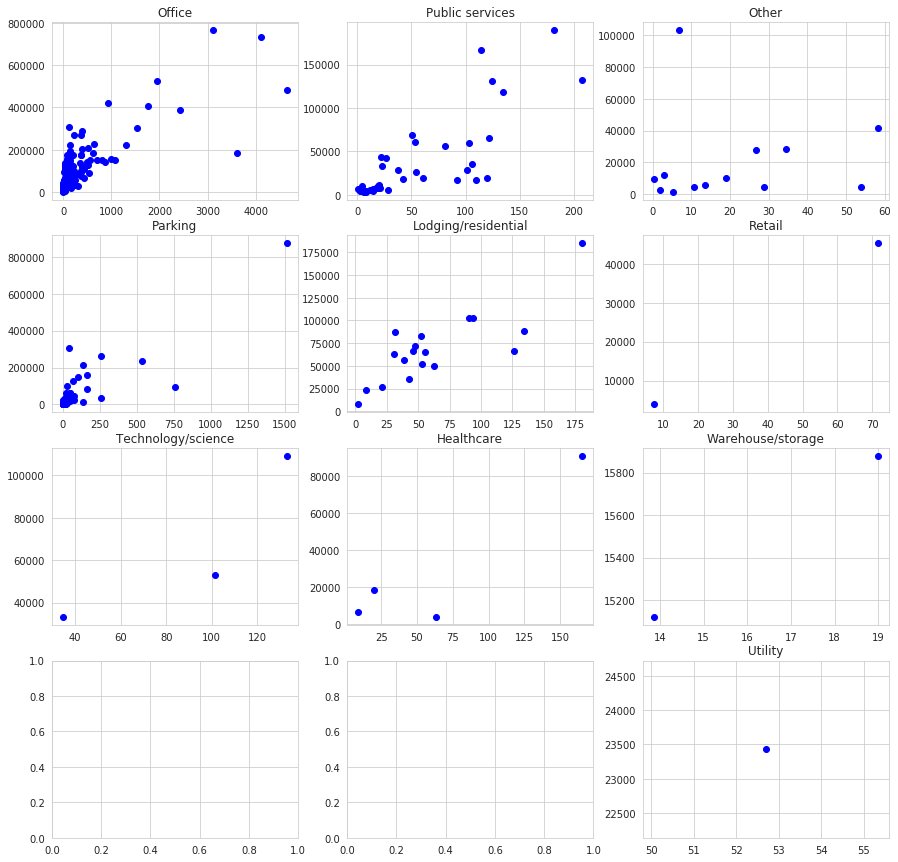

In [15]:
i=0
j=0
M = year_cons_mean['primary_use'].unique()
fig, ax = plt.subplots(4,3, figsize=(15,15))
for i in range(len(M)):
    df2 = year_cons_mean[year_cons_mean['primary_use']==M[i]]
    ax[int(i/4), j].title.set_text(f'{M[i]}')
    ax[int(i/4), j].plot(df2['mean_cons'], df2['square_feet'], 'bo')
    if i%3 !=0:
        j = j+1
    else:
        j=0

In [16]:
i=0
corr={}
M = year_cons_mean['primary_use'].unique()
for i in range(len(M)):
    df2 = year_cons_mean[year_cons_mean['primary_use']==M[i]][['mean_cons','square_feet','total_area']]
    if len(df2['mean_cons'])>15:
        corr[f'{M[i]}'] = df2.corr()['mean_cons']
bold('**Correlation with the mean consumption per type of use, primary uses with less than 15 values were droped**')
pd.DataFrame.from_dict(corr, orient='index').drop(columns='mean_cons')

**Correlation with the mean consumption per type of use, primary uses with less than 15 values were droped**

square_feet  total_area
Education                         0.799978    0.647110
Office                            0.725860    0.547070
Public services                   0.793675    0.728008
Entertainment/public assembly     0.893591    0.562788
Lodging/residential               0.819763    0.530871

Here we can see that the square_feet area is better correlated than the total area, so maybe the square_feet already is the total area of the buildings and we don't need to multiply by the number of floors.\
It follows from this analysis that we can just drop the floor count variable.\

##### **year_built**
55% of missing values for this variable.

In [21]:
A = building_metadata[building_metadata['year_built'].notnull()].groupby('primary_use').agg({
        'year_built': ['count', 'mean', 'std', min, max]
    })
B = building_metadata.groupby('primary_use').agg({
        'primary_use': 'count'
    })
pd.concat([B, A], axis=1, sort=False)

primary_use  (year_built, count)  \
primary_use                                                       
Education                              549                  326   
Entertainment/public assembly          184                   73   
Food sales and service                   5                    1   
Healthcare                              23                    8   
Lodging/residential                    147                   85   
Manufacturing/industrial                12                    6   
Office                                 279                   85   
Other                                   25                    6   
Parking                                 22                   14   
Public services                        156                   51   
Religious worship                        3                    2   
Retail                                  11                    7   
Services                                10                    0   
Technology/science                       6                    3   
Utility                                  4                    3   
Warehouse/storage                       13                    5   

                               (year_built, mean)  (year_built, std)  \
primary_use                                                            
Education                                  1963.0          31.843750   
Entertainment/public assembly              1971.0          28.734375   
Food sales and service                     2012.0                NaN   
Healthcare                                 1982.0          37.250000   
Lodging/residential                        1973.0          30.859375   
Manufacturing/industrial                   1958.0          23.890625   
Office                                     1973.0          28.406250   
Other                                      1982.0           9.851562   
Parking                                    1998.0          14.515625   
Public services                            1964.0          30.375000   
Religious worship                          1979.0          43.843750   
Retail                                     1998.0          15.812500   
Services                                      NaN                NaN   
Technology/science                         1939.0          25.625000   
Utility                                    1976.0          31.781250   
Warehouse/storage                          1983.0          12.523438   

                               (year_built, min)  (year_built, max)  
primary_use                                                          
Education                                 1900.0             2017.0  
Entertainment/public assembly             1900.0             2016.0  
Food sales and service                    2012.0             2012.0  
Healthcare                                1922.0             2014.0  
Lodging/residential                       1900.0             2013.0  
Manufacturing/industrial                  1919.0             1976.0  
Office                                    1904.0             2016.0  
Other                                     1968.0             1996.0  
Parking                                   1955.0             2014.0  
Public services                           1900.0             2014.0  
Religious worship                         1948.0             2010.0  
Retail                                    1980.0             2016.0  
Services                                     NaN                NaN  
Technology/science                        1912.0             1963.0  
Utility                                   1940.0             1999.0  
Warehouse/storage                         1975.0             2005.0

One possible way is to fill the year_built missing values with values generated by a normal distribution with mean and std for each primary_use.

In [22]:
M = train_sample['primary_use'].unique()
df1 = pd.DataFrame(columns=['year_built'])
for i in range(len(M)):
    df = building_metadata[building_metadata['primary_use']==M[i]][['year_built']]
    std = A.loc[M[i], ( 'year_built', 'std')]
    mean = A.loc[M[i], ( 'year_built', 'mean')]
    df1 = df1.append(df.where(df.notnull(), np.random.normal(mean,std)))


new_building_metadata = {}

i=0
for i in train_sample['building_id'].unique():
    new_building_metadata[f'{i}']= df1.loc[i]['year_built']
new_building_metadata = pd.DataFrame.from_dict(new_building_metadata, orient='index', columns=['year_built'])
new_building_metadata = new_building_metadata.where(new_building_metadata['year_built'].notnull(), 1989)
new_building_metadata = new_building_metadata.reset_index().rename(columns={"index": "building_id"})
new_building_metadata['building_id'] = new_building_metadata['building_id'].astype(np.int)


##### c- Weather data:

As we have noticed earlier there are some missing chunks of the weather data that can't be reconstructed just by simple interpolation.
The most importat number of missing values is for these variables:
cloud_coverage	43.6%
precip_depth_1_hr	18.5%
wind_direction	7.1%
sea_level_pressure	6.1%
We think a priori that these variables don't affect much the energie consumption, so for now we will drop these variables.
for the remaining weather variables the missing values account for less than 1%, so we think we can do without them.

In [23]:
train_sample = train_sample.drop(columns=['cloud_coverage', 'precip_depth_1_hr', 'wind_direction', 'meter', 'floor_count',
                                         'sea_level_pressure', 'year_built', 'timestamp'])

In [24]:
train_sample = train_sample.merge(new_building_metadata, on='building_id', how='left').dropna()

In [25]:
train_sample_labels = train_sample["meter_reading"].copy()
train_sample = train_sample.drop("meter_reading", axis=1)

In [24]:
train_sample

building_id  site_id                    primary_use  square_feet  \
0                190        2                      Education       137040   
1                625        4                      Education        55516   
2                304        3  Entertainment/public assembly       194300   
3               1205       13                        Parking       178270   
4               1222       13            Lodging/residential       187174   
...              ...      ...                            ...          ...   
9371751          466        3                Public services        22500   
9371752         1263       14                      Education        97838   
9371753          162        2                      Education        98829   
9371754         1441       15                      Education        30143   
9371755          203        2            Lodging/residential        63348   

         air_temperature  dew_temperature  wind_speed  year  weekday_sin  \
0              35.000000        16.703125    4.601562   116     0.433884   
1              12.203125         7.199219    4.601562   116    -0.974928   
2               6.699219         5.601562    4.101562   116     0.433884   
3              13.898438        10.000000    5.101562   116     0.781831   
4              26.093750        20.000000    2.599609   116    -0.433884   
...                  ...              ...         ...   ...          ...   
9371751        23.296875        13.898438    0.000000   116     0.974928   
9371752        -3.300781        -8.296875    0.000000   116    -0.781831   
9371753        17.796875        -6.699219    2.599609   116     0.974928   
9371754        28.906250        18.906250    4.101562   116     0.433884   
9371755        10.601562         6.699219    2.099609   116     0.974928   

             hour_sin   day_sin     month_sin  year_built  
0       -2.588190e-01  0.998717 -1.000000e+00      1957.0  
1        9.659258e-01 -0.848644 -5.000000e-01      1978.0  
2       -8.660254e-01 -0.394356 -2.449294e-16      1900.0  
3        0.000000e+00  0.101168  1.000000e+00      1982.0  
4        2.588190e-01  0.651372 -8.660254e-01      1950.0  
...               ...       ...           ...         ...  
9371751 -5.000000e-01 -0.937752  5.000000e-01      1947.0  
9371752  1.224647e-16  0.790776 -2.449294e-16      1968.0  
9371753  2.588190e-01  0.485302  5.000000e-01      1968.0  
9371754 -1.000000e+00  0.724793 -8.660254e-01      1951.0  
9371755  9.659258e-01 -0.571268 -2.449294e-16      2007.0  

[9316375 rows x 13 columns]

### IV- Preparing the Data for Machine Learning Algorithms:
#### 1-Handling Text and Categorical Attributes:

Most Machine Learning algorithms prefer to work numbers , so let’s convert text labels in the data to numbers

In [26]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
primary_use = train_sample["primary_use"].astype(str).unique()
primary_use_encoded = encoder.fit_transform(primary_use)
primary_use_encoded
train_sample["primary_use"] = encoder.transform(train_sample["primary_use"].astype(str))

In [26]:
train_sample

building_id  site_id  primary_use  square_feet  air_temperature  \
0                190        2            1       137040        35.000000   
1                625        4            1        55516        12.203125   
2                304        3            0       194300         6.699219   
3               1205       13            0       178270        13.898438   
4               1222       13            0       187174        26.093750   
...              ...      ...          ...          ...              ...   
9371751          466        3            0        22500        23.296875   
9371752         1263       14            1        97838        -3.300781   
9371753          162        2            1        98829        17.796875   
9371754         1441       15            1        30143        28.906250   
9371755          203        2            0        63348        10.601562   

         dew_temperature  wind_speed  year  weekday_sin      hour_sin  \
0              16.703125    4.601562   116     0.433884 -2.588190e-01   
1               7.199219    4.601562   116    -0.974928  9.659258e-01   
2               5.601562    4.101562   116     0.433884 -8.660254e-01   
3              10.000000    5.101562   116     0.781831  0.000000e+00   
4              20.000000    2.599609   116    -0.433884  2.588190e-01   
...                  ...         ...   ...          ...           ...   
9371751        13.898438    0.000000   116     0.974928 -5.000000e-01   
9371752        -8.296875    0.000000   116    -0.781831  1.224647e-16   
9371753        -6.699219    2.599609   116     0.974928  2.588190e-01   
9371754        18.906250    4.101562   116     0.433884 -1.000000e+00   
9371755         6.699219    2.099609   116     0.974928  9.659258e-01   

          day_sin     month_sin  year_built  
0        0.998717 -1.000000e+00      1957.0  
1       -0.848644 -5.000000e-01      1978.0  
2       -0.394356 -2.449294e-16      1900.0  
3        0.101168  1.000000e+00      1982.0  
4        0.651372 -8.660254e-01      1950.0  
...           ...           ...         ...  
9371751 -0.937752  5.000000e-01      1947.0  
9371752  0.790776 -2.449294e-16      1968.0  
9371753  0.485302  5.000000e-01      1968.0  
9371754  0.724793 -8.660254e-01      1951.0  
9371755 -0.571268 -2.449294e-16      2007.0  

[9316375 rows x 13 columns]

#### 2- Feature scaling:

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

train_sample_scaled = scaler.fit_transform(train_sample.drop(["primary_use", "wind direction", 
                                                              "site_id", "building_id"], axis=1))

Note: Decision trees don't feature scaling.

### IV- Experimenting with some ML algorithms:

In this section we are going to mainly experiment with decision trees based models.
Our motivation for this choice is that Decision Trees are versatile Machine Learning algorithms that can perform both classification and regression tasks. They are very powerful algorithms, capable of fitting complex datasets, and they are relatively simple to implement.
We are going to explore the maximum depth that an non restricted tree is going to attain, this will be a guide for future exploration. We are going to experiment with random forest as a bagging method and with Xgboost as a boosting method.

#### 1-Decision trees:
Here we use a decision tree regressor to see how it fits the data, it's like the decision tree classifier except that instead of trying to split the training set in a way that minimizes impurity of the classes, it tries to split the training set in a way that minimizes the Mean Square Error.

In [27]:
from sklearn.tree import DecisionTreeRegressor

In [26]:
tree_reg = DecisionTreeRegressor()

In [27]:
tree_reg.fit(train_sample, train_sample_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [28]:
meter_reading_predictions = tree_reg.predict(train_sample)

In [29]:
from sklearn.metrics import mean_squared_error

tree_mse = mean_squared_error(train_sample_labels, meter_reading_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

1.6099092261880537

In [30]:
tree_reg.get_depth()

58

In [31]:
tree_reg.get_n_leaves()

8332817

We ran the algorithm without specifying any hyperparameter to see how deep it's gonna go.
As we see the depth got to 58 and the number of leaves is almost the same as the number of labels. So, obviously this tree is overfitting the training data and will not generalize well.

To improve this we can use Ensemble Learning and Random Forests on cross validation subsets of the training data.

#### 2- A random forest:
Here we are going to use a random forest of 50 trees with max depth of 16, just to see what results we get.
We are going also to use Out-of-Bag Evaluation which is a technique that evaluates the trees generated by the random forest on the subset that they were not trained on. This evaluation is claimed to give almost the same results as if it was done on the separated test sample - Breiman, L. [1996a] (we will verify this claim in this exercise)

In [28]:
from sklearn.ensemble import RandomForestRegressor


In [63]:
rnd_reg = RandomForestRegressor(n_estimators=50, max_depth=15, n_jobs=7, oob_score=True)

rnd_reg.fit(train_sample, train_sample_labels)

meter_reading_predictions = rnd_reg.predict(train_sample)


In [29]:
from sklearn.metrics import mean_squared_error


In [64]:
rnd_reg_mse = mean_squared_error(train_sample_labels, meter_reading_predictions)
rnd_reg_rmse = np.sqrt(rnd_reg_mse)
print(rnd_reg_rmse)
rnd_reg.oob_score_

87.97753645383078


0.9298434372645701

Wow! we get an R2 score of 93% on out of bag elements for a max_depth = 15. This is very promising. We should explore more.

In fact, the choice of our parameter was somewhat random, the choice of the number of trees in our forest was restricted by the power of our PC's and the max_depth was chosen taking in consideration that a tree of max_depth=58 overfits the data.\ 
We should try other parameter values to see what difference it is going to make.\ 
Random forest have a multitude of hyperparameters they include almost all the parameters of random tress and of bagging methods, the most important ones are:
- n_estimators = number of trees in the foreset
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)

We can use a grid search or a randomized search to explore multiple configurations, we chose randomized search to have more control over the computation time.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {"max_depth": [15, 40],
              "max_features": randint(5, 13),
              "bootstrap": [True, False]}

forest_reg = RandomForestRegressor(n_jobs=-1, n_estimators=50)

random_search = RandomizedSearchCV(forest_reg, param_distributions=param_dist,
                                   n_iter=5, iid=False)


random_search.fit(train_sample, train_sample_labels)

This search was overloading 30 Gb of memory! (22 swap and 8 ram) we couldn't finish it.
So we decided to drop this and do some manual search.

In [61]:
rnd_reg = RandomForestRegressor(n_estimators=50, max_depth=25, n_jobs=-1, oob_score=True)

rnd_reg.fit(train_sample, train_sample_labels)

meter_reading_predictions = rnd_reg.predict(train_sample)

rnd_reg_mse = mean_squared_error(train_sample_labels, meter_reading_predictions)
rnd_reg_rmse = np.sqrt(rnd_reg_mse)
print(rnd_reg_rmse)
rnd_reg.oob_score_

38.4069697660443


0.9507886607125677

Increasing the max_depth to 25 improved the oob_score to 95% and reduced considerably the rmse, unfortunately it takes a lot of time to execute the code so we can't explore more for now.\
Meanwhile, let's check feature importance:

In [62]:
importances = rnd_reg.feature_importances_
std = np.std([tree.feature_importances_ for tree in rnd_reg.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

Feature ranking:
3. square_feet (0.475077)
0. building_id (0.175558)
2. primary_use (0.088829)
12. year_built (0.084046)
4. air_temperature (0.045649)
11. month_sin (0.033080)
5. dew_temperature (0.029811)
1. site_id (0.018832)
8. weekday_sin (0.014981)
10. day_sin (0.013366)
9. hour_sin (0.012227)
6. wind_speed (0.008544)
7. year (0.000000)


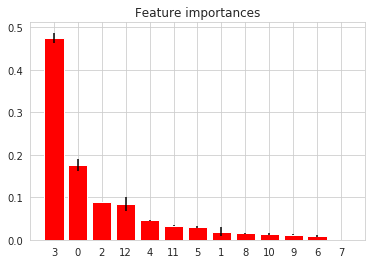

In [63]:
# Print the feature ranking
print("Feature ranking:")

for f in range(train_sample.shape[1]):
    print("%d. %s (%f)" % (indices[f], train_sample.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(train_sample.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(train_sample.shape[1]), indices)
plt.xlim([-1, train_sample.shape[1]])
plt.show()

As we see the most important feature is the square_feet, this confirms our earlier hypothesis that the square_feet expresses the net area of the building not just it's footprint.

Let's run our model now on the train set to see if it's going to generalize well:

In [47]:
test_sample['timestamp'] = pd.to_datetime(test_sample['timestamp'])
test_sample = transform(test_sample)
test_sample = encode_cyclic_feature(test_sample, 'weekday', 7)
test_sample = encode_cyclic_feature(test_sample, 'hour', 24)
test_sample = encode_cyclic_feature(test_sample, 'day', 31)
test_sample = encode_cyclic_feature(test_sample, 'month', 12)

In [ ]:
M = test_sample['primary_use'].unique()
df1 = pd.DataFrame(columns=['year_built'])
for i in range(len(M)):
    df = building_metadata[building_metadata['primary_use']==M[i]][['year_built']]
    std = A.loc[M[i], ( 'year_built', 'std')]
    mean = A.loc[M[i], ( 'year_built', 'mean')]
    df1 = df1.append(df.where(df.notnull(), np.random.normal(mean,std)))


new_building_metadata = {}

i=0
for i in test_sample['building_id'].unique():
    new_building_metadata[f'{i}']= df1.loc[i]['year_built']
new_building_metadata = pd.DataFrame.from_dict(new_building_metadata, orient='index', columns=['year_built'])
new_building_metadata = new_building_metadata.where(new_building_metadata['year_built'].notnull(), 1989)
new_building_metadata = new_building_metadata.reset_index().rename(columns={"index": "building_id"})
new_building_metadata['building_id'] = new_building_metadata['building_id'].astype(np.int)

test_sample = test_sample.drop(columns=['cloud_coverage', 'precip_depth_1_hr', 'wind_direction', 'meter', 'floor_count',
                                         'sea_level_pressure', 'year_built', 'timestamp'])


test_sample = test_sample.merge(new_building_metadata, on='building_id', how='left').dropna()


test_sample_labels = test_sample["meter_reading"].copy()
test_sample = test_sample.drop("meter_reading", axis=1)


encoder = LabelBinarizer()
primary_use = test_sample["primary_use"].astype(str).unique()
primary_use_encoded = encoder.fit_transform(primary_use)
primary_use_encoded
test_sample["primary_use"] = encoder.transform(test_sample["primary_use"].astype(str))

In [51]:
test_sample["primary_use"] = encoder.transform(test_sample["primary_use"].astype(str))

In [62]:
test_reading_predictions = rnd_reg.predict(test_sample)
rnd_reg_mse_test = mean_squared_error(test_sample_labels, test_reading_predictions)
rnd_reg_rmse_test = np.sqrt(rnd_reg_mse_test)
print(rnd_reg_rmse_test)
rnd_reg.score(test_sample, test_sample_labels)

116.8273359139766


0.9071508046273399

It gives a slightly worst result than for the oob_set, but it's still a good score for these first iterations of the model.

#### 3- Xgboost :
The other type of ensemble learning that enhances the trees performance is boosting algorithms. Xgboost is currently the most popular one, it's known for being a quick and robust algorithm, it normally uses eXtrem random trees as it's base learners. The most important parameters of this model are:
- learning_rate: step size shrinkage used to prevent overfitting. Range is [0,1]
- max_depth: determines how deeply each tree is allowed to grow during any boosting round.
- subsample: percentage of samples used per tree. A low value can lead to underfitting.
- colsample_bytree: percentage of features used per tree. A high value can lead to overfitting.
- n_estimators: number of trees you want to build.
- objective: determines the loss function to be used like reg:linear for regression problems, reg:logistic for classification problems with only decision, binary:logistic for classification problems with probability.

XGBoost also supports regularization parameters to penalize models as they become more complex and reduce them to simple (parsimonious) models.
- gamma: controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. Supported only for tree-based learners.
- alpha: L1 regularization on leaf weights. A large value leads to more regularization.
- lambda: L2 regularization on leaf weights and is smoother than L1 regularization.

In [30]:
data_dmatrix = xgb.DMatrix(data=train_sample,label=train_sample_labels)

/home/anas/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



In [ ]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 15, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

In [51]:
cv_results.head()

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0       389.287921        0.424922      389.499884       1.754939
1       378.878308        3.299718      379.099054       4.609394
2       363.687024        3.263563      363.928277       4.558056
3       354.720587        5.728005      355.038538       6.971787
4       347.444061        6.029038      347.869177       7.465084

In [52]:
print((cv_results["test-rmse-mean"]).tail(1))

49    210.919663
Name: test-rmse-mean, dtype: float64


The result on xgboosting with cross validation to find the best tree of depth_max = 15, was unimpressive, it took a much more time in execution and gave much worse results than the random forest model with the same depth_max.
We should increase the complexity of the learners and/or the number of boosting rounds to maybe get better results, but the risk with this is overfitting.\
Another way is to combine the two methods boosting and bagging, this is what we are going to explore next.

#### 4- Taking it further: Combining Xgboost and random forests
These two algorithm could be combined in two ways:\
Using random forests as basic learners for Xgboost.\
Xgboosting trees to constitute a random forest, this called Xgboosting a standalone random forest.\

### References:
- Aurélien Géron - Hands-On Machine Learning with Scikit-Learn and TensorFlow Concepts, Tools, and Techniques to Build Intelligent Systems-O’Reilly Media (2017)
- https://www.kaggle.com/c/ashrae-energy-prediction/data?fbclid=IwAR1XCqLG-1dDaHvBodjPiVnZLjE1nVP_RWoFHkhjPiI8sbd2crB-HEBSYx8
- https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning
- https://www.datacamp.com/community/tutorials/xgboost-in-python
- https://xgboost.readthedocs.io/en/latest/tutorials/rf.html
- OUT-OF-BAG ESTIMATION -Leo Breiman* Statistics Department University of California Berkeley, CA. 94708
